In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
import tensorflow as tf
from pathlib import Path
from time import strftime
from shutil import rmtree
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.use("TKAgg", force=True)
%matplotlib inline
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import OnlinePhotometry, SimulationParams
from rtapipe.lib.plotting.plotting import plot_sequences
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_from_pvalue, get_sigma_for_ts_array, get_sigma_from_ts

# Loading the models

In [3]:
def load_model(model_id):
    with open("./trained_models.yaml", "r") as f:
        try:
            configs = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
    model_config = [c for c in configs["models"] if c["id"] == model_id]
    model_config = dotdict(model_config.pop())
    model_config.ad = AnomalyDetectorBuilder.getAnomalyDetector(name=model_config.name, timesteps=model_config.timesteps, nfeatures=model_config.nfeatures, load_model="True", training_epoch_dir=model_config.path, training=False)
    model_config.pvalue_table = get_pval_table(model_config.pval_path) 
    return model_config

In [4]:
model_config_cnn = load_model(0)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 0,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19',
 'epoch': 19,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_19/pvalues/pval_20221118-113940/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2b599633bcd0>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.003171       0.000

In [5]:
model_config_rnn = load_model(1)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 1,
 'patience': 5,
 'integrationtime': 5,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10',
 'epoch': 10,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/epochs/epoch_10/pvalues/pval_20221121-132236/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221116-101109_mr_patience_5/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_5_a_tsl_5_nbins_3_tsl_3600/fitted_scaler.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2b5a13face20>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000227       0.000

# Loading the test dataset

In [6]:
output_dir = "./logs/test_models_dataset_itime_5_h_out"

In [7]:
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]

In [8]:
data_manager = DataManager(output_dir)

In [9]:
dataset_id="test_itime_5_c_tsl_5_nbins_3"

In [10]:
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/itime_5_h/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)

Loaded 419 files


In [11]:
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 5
number_of_energy_bins = 3
tsl = 100
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(5, 100)

Loading cached data from run0002_ID000044_it_5_tsl_100.npy
Loading cached data from run0005_ID000225_it_5_tsl_100.npy
Loading cached data from run0009_ID000191_it_5_tsl_100.npy
Loading cached data from run0011_ID000139_it_5_tsl_100.npy
Loading cached data from run0013_ID000321_it_5_tsl_100.npy
Loading cached data from run0016_ID000340_it_5_tsl_100.npy
Loading cached data from run0017_ID000132_it_5_tsl_100.npy
Loading cached data from run0017_ID000261_it_5_tsl_100.npy
Loading cached data from run0017_ID000302_it_5_tsl_100.npy
Loading cached data from run0019_ID000070_it_5_tsl_100.npy
Loading cached data from run0019_ID000268_it_5_tsl_100.npy
Loading cached data from run0019_ID000338_it_5_tsl_100.npy
Loading cached data from run0021_ID000373_it_5_tsl_100.npy
Loading cached data from run0023_ID000267_it_5_tsl_100.npy
Loading cached data from run0025_ID000471_it_5_tsl_100.npy
Loading cached data from run0026_ID000127_it_5_tsl_100.npy
Loading cached data from run0027_ID000288_it_5_tsl_100.n

In [12]:

assert len(data_manager.data) == test_set_size

## Plot some samples

In [13]:
for template in list(data_manager.data.keys())[0:5]:
    data_manager.plot_timeseries(template, data_manager.data[template], 1, sim_params, output_dir, labels=features_names)

Produced: logs/test_models_dataset_itime_5_h_out/template_run0002_ID000044_trial_0_2022-12-20 18:17:15.671036.png
Saved: ./logs/test_models_dataset_itime_5_h_out/template_run0002_ID000044_trial_0_2022-12-20 18:17:15.671036.png
Produced: logs/test_models_dataset_itime_5_h_out/template_run0005_ID000225_trial_0_2022-12-20 18:17:19.026991.png
Saved: ./logs/test_models_dataset_itime_5_h_out/template_run0005_ID000225_trial_0_2022-12-20 18:17:19.026991.png
Produced: logs/test_models_dataset_itime_5_h_out/template_run0009_ID000191_trial_0_2022-12-20 18:17:21.304527.png
Saved: ./logs/test_models_dataset_itime_5_h_out/template_run0009_ID000191_trial_0_2022-12-20 18:17:21.304527.png
Produced: logs/test_models_dataset_itime_5_h_out/template_run0011_ID000139_trial_0_2022-12-20 18:17:24.093790.png
Saved: ./logs/test_models_dataset_itime_5_h_out/template_run0011_ID000139_trial_0_2022-12-20 18:17:24.093790.png
Produced: logs/test_models_dataset_itime_5_h_out/template_run0013_ID000321_trial_0_2022-12-2

# TESTING

In [14]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [15]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2022-12-20 18:17:29.457173] Total x shape shape: (40224, 5, 3)
[2022-12-20 18:17:29.457236] Total y shape shape: (40224,)


# RNN

## Standard metrics - 3 sigma threshold

In [16]:
model_config_rnn.pvalue_table


,threshold,threshold_err,pvalue,pvalue_err,sigma
0,0.000227,0.000013,1.416930e-01,1.254772e-04,1.073
1,0.000253,0.000013,9.859137e-02,1.046671e-04,1.290
2,0.000279,0.000013,6.802256e-02,8.693953e-05,1.491
3,0.000305,0.000013,4.666059e-02,7.200554e-05,1.678
4,0.000331,0.000013,3.223601e-02,5.984963e-05,1.849
...,...,...,...,...,...
87,0.002495,0.000013,1.111173e-07,1.111173e-07,5.180
88,0.002521,0.000013,1.111173e-07,1.111173e-07,5.180
89,0.002547,0.000013,1.111173e-07,1.111173e-07,5.180
90,0.002574,0.000013,1.111173e-07,1.111173e-07,5.180


In [17]:
SIGMA_THRESHOLD = 3

In [18]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0005921241825 corresponding to 3.0060572682 sigma


In [19]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0005921241825
accuracy 0.6588852426412092
precision 0.9978070175438597
recall 0.3324241391067167
f1 0.49870300683204855
roc_auc 0.665831223567475
confusion_matrix [[19678, 15], [13706, 6825]]
false_positive_rate 0.0021929824561403508
detection_delay: 5.577565632458234


## Standard metrics - 5 sigma threshold

In [20]:
SIGMA_THRESHOLD = 5

In [21]:
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.0020782086315 corresponding to 5.0488536162 sigma


In [22]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.0020782086315
accuracy 0.6180887032617343
precision 0.9982648930017352
recall 0.25220398421898593
f1 0.402675169142235
roc_auc 0.6258734845179631
confusion_matrix [[19684, 9], [15353, 5178]]
false_positive_rate 0.001735106998264893
detection_delay: 2.4463007159904535


## Sigma table

In [23]:
def crop_to_5(s):
    if s > 5: 
        s = 5.00001
    return s

In [24]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_rnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)

100%|████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:28<00:00, 14.89it/s]


In [25]:
sigma_table_rnn

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

# CNN

## Standard metrics - 3 sigma

In [26]:
SIGMA_THRESHOLD = 3

In [27]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.006506945827 corresponding to 3.0286528291 sigma


In [28]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.006506945827
accuracy 0.630071599045346
precision 0.9982366425674484
recall 0.27572938483269205
f1 0.43210441950996104
roc_auc 0.6376107950924237
confusion_matrix [[19683, 10], [14870, 5661]]
false_positive_rate 0.0017633574325515782
detection_delay: 3.5250596658711215


## Standard metrics - 5 sigma

In [29]:
SIGMA_THRESHOLD = 5

In [30]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0139048776129999 corresponding to 5.0465140766 sigma


In [31]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0139048776129999
accuracy 0.5995922832140016
precision 0.9986477349560514
recall 0.2158199795431299
f1 0.35493431592438324
roc_auc 0.6077576513772116
confusion_matrix [[19687, 6], [16100, 4431]]
false_positive_rate 0.001352265043948614
detection_delay: 2.360381861575179


## Sigma table

In [32]:
data = {}
for template in tqdm(list(data_manager.data.keys())):
    test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=5, sub_window_size=5, stride=1)
    model_config_cnn.ad.predict(test_x)
    data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(96, 5, 5, 1))    
sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)
sigma_table_cnn

100%|████████████████████████████████████████████████████████████████████████████████████████| 419/419 [00:19<00:00, 21.71it/s]


,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

In [33]:
sigma_table_cnn

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

# Li&Ma

In [34]:
li_ma_data = {}
templates = list(data_manager.data.keys())
templates = []
for template in tqdm(templates):
    lima_df = LiMa.detect("binned", DataManager.get_fits_from_template(fits_files, template), temporal_bins=sigma_table_cnn.index.values, tobs=500, sigma_gt=0)
    li_ma_data[template] = lima_df["sigma"].values
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_cnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("li_ma_detection_table.csv"))    

100%|████████████████████████████████████████████████████████████████████████████████████████| 419/419 [09:49<00:00,  1.41s/it]


In [35]:
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("li_ma_detection_table.csv"), index_col=0)

In [36]:
### FIX INDEPENDENCE
for time_bin in lima_sigma_table.index:
    if int(time_bin.split("-")[1])%25 != 0:
        lima_sigma_table.loc[time_bin] = 0
lima_sigma_table

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

In [37]:
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
lima_sigma_table

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

## Results

In [38]:
templates_detections = dotdict({})
for templ_det in lima_sigma_table:
    templates_detections[templ_det] = dotdict({}) 
    templates_detections[templ_det]["li_ma"] = dotdict({})
    templates_detections[templ_det]["cnn"] = dotdict({})
    templates_detections[templ_det]["rnn"] = dotdict({})

In [39]:
for templ_det in lima_sigma_table:
    detections_3s = lima_sigma_table[templ_det] >= 3
    detections_5s = lima_sigma_table[templ_det] >= 5
    templates_detections[templ_det]["li_ma"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["li_ma"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["li_ma"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["li_ma"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]

for templ_det in sigma_table_rnn:
    detections_3s = sigma_table_rnn[templ_det] >= 3
    detections_5s = sigma_table_rnn[templ_det] >= 5
    templates_detections[templ_det]["rnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["rnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["rnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["rnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]
    
for templ_det in sigma_table_cnn:
    detections_3s = sigma_table_cnn[templ_det] >= 3
    detections_5s = sigma_table_cnn[templ_det] >= 5
    templates_detections[templ_det]["cnn"]["3s_detection"] = detections_3s.any()
    templates_detections[templ_det]["cnn"]["5s_detection"] = detections_5s.any()
    templates_detections[templ_det]["cnn"]["3s_detections_indexes"] = np.where(detections_3s == True)[0]
    templates_detections[templ_det]["cnn"]["5s_detections_indexes"] = np.where(detections_5s == True)[0]    

In [40]:
def get_first_detections(templates_detections, model, sigma=5):
    first_detection_indexes = []
    for template_result in templates_detections.values():
            if len(template_result[model][f"{sigma}s_detections_indexes"]) > 0:
                first_detection_indexes.append(template_result[model][f"{sigma}s_detections_indexes"][0])
    return np.array(sorted(first_detection_indexes))*5 

In [41]:
lima_first_d = get_first_detections(templates_detections, "li_ma")
ad_first_d = get_first_detections(templates_detections, "rnn")

In [42]:
bins = [i for i in range(0,500,5)]

196 146


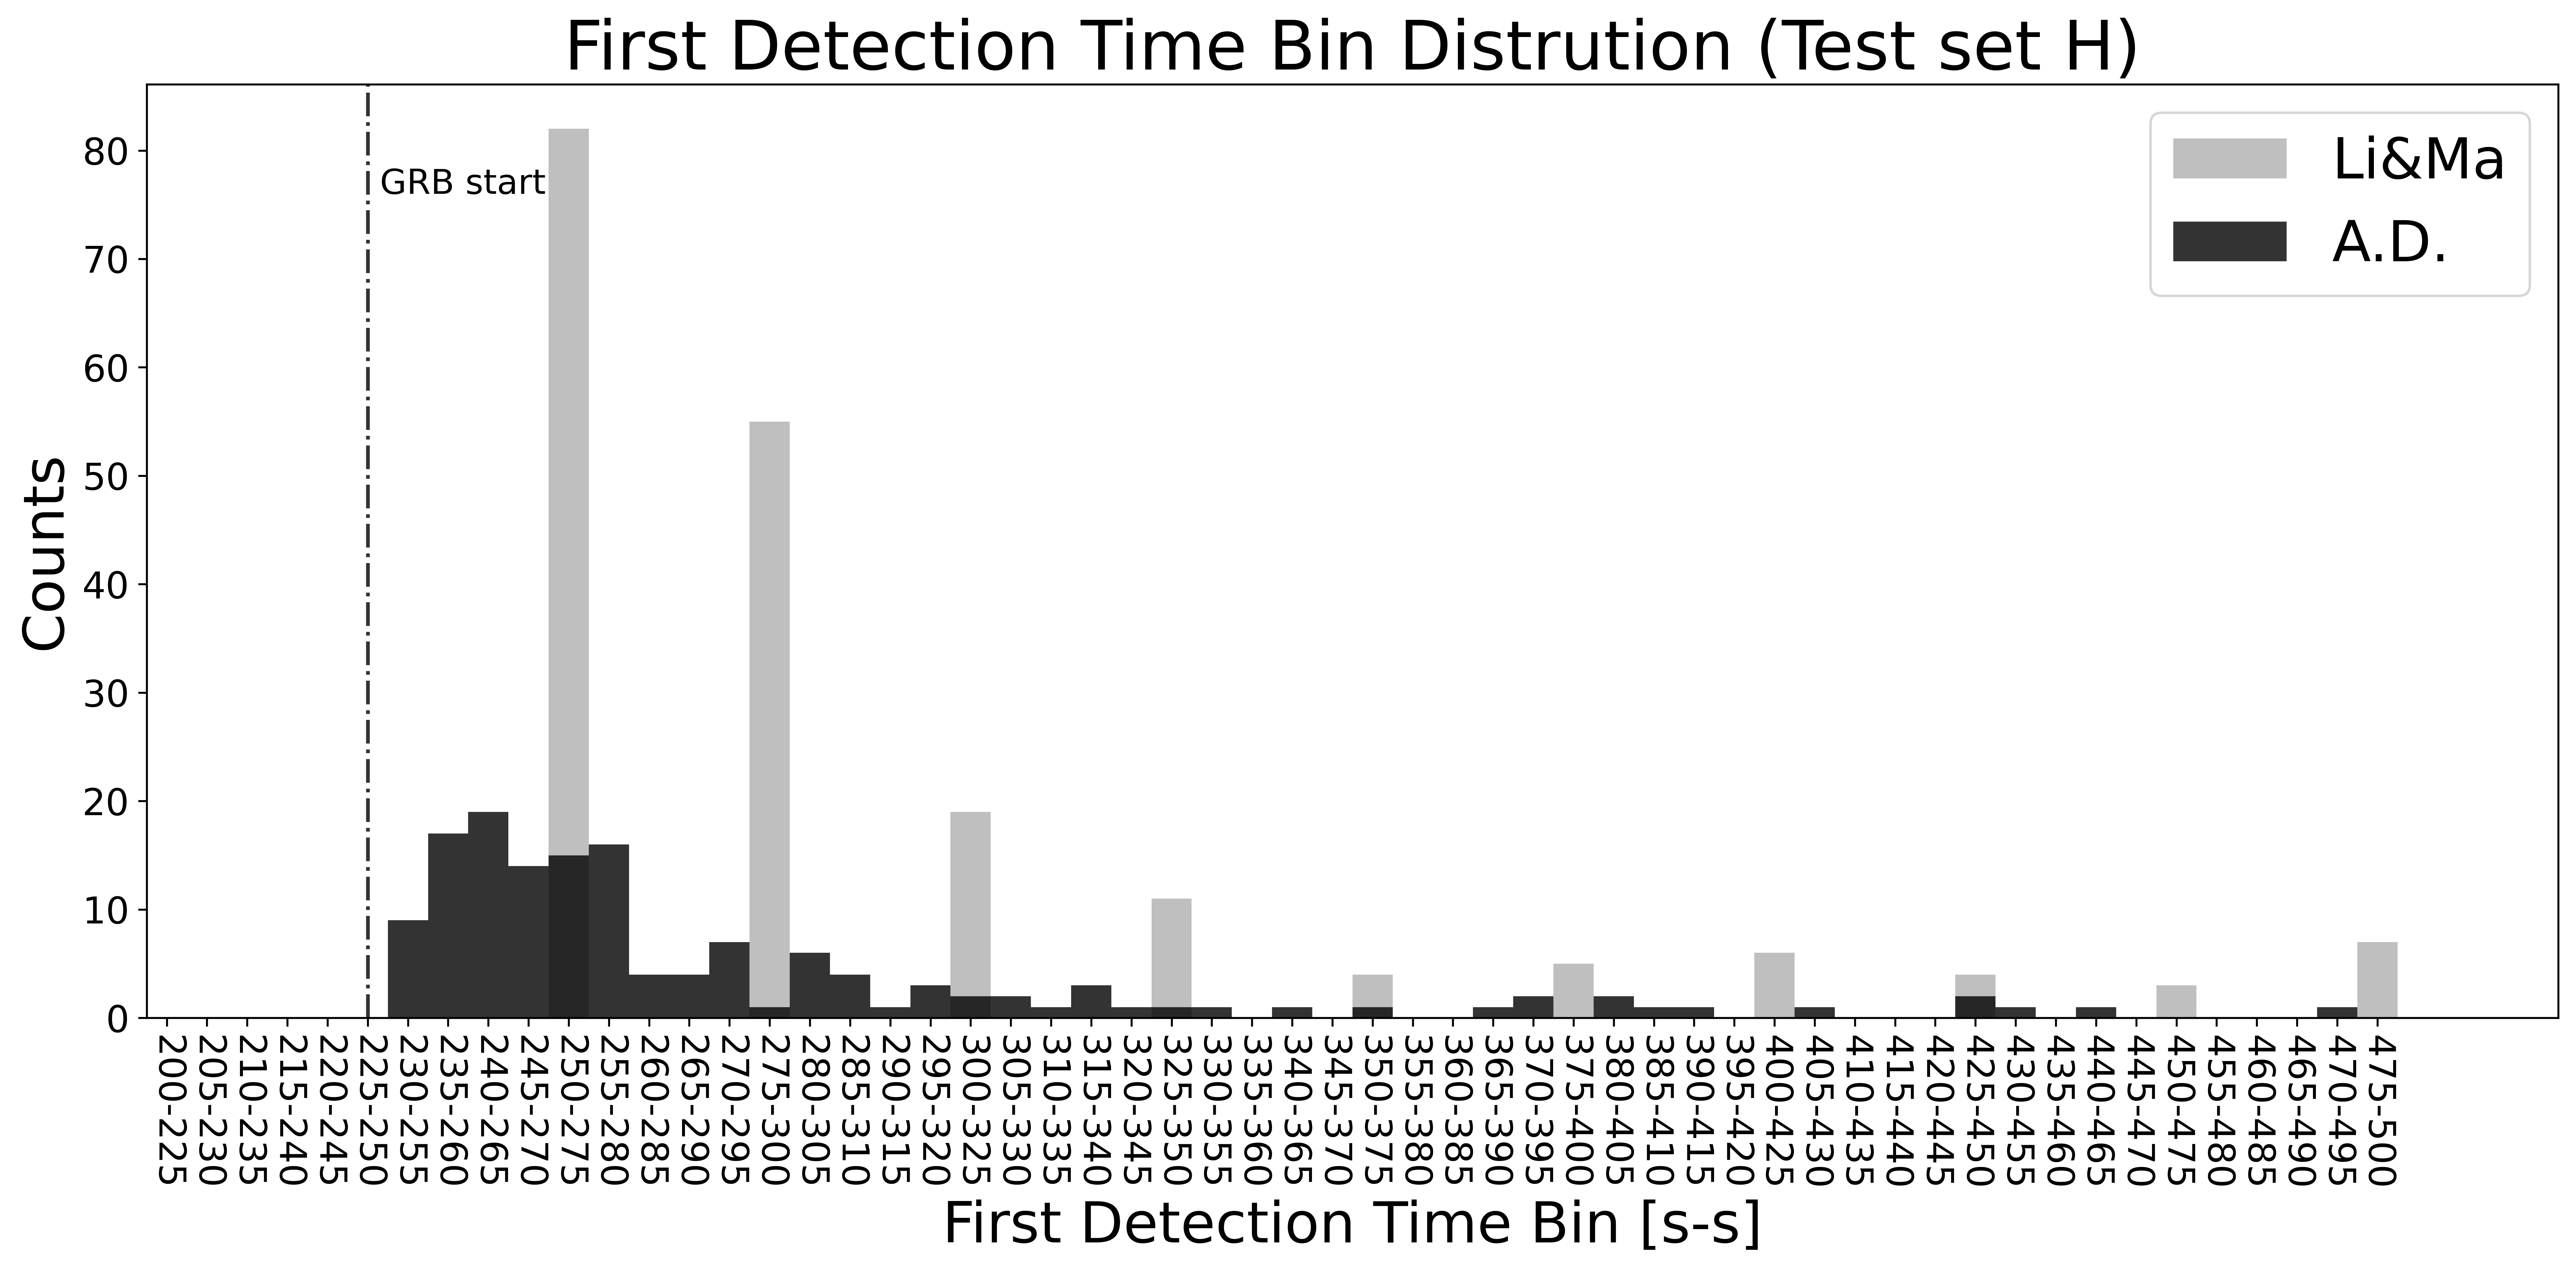

In [43]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
pc = PlotConfig()
fig, ax = plt.subplots(1,1,figsize=pc.fig_size)
print(len(lima_first_d), len(ad_first_d))

counts_li_ma, bins_li_ma = np.histogram(lima_first_d, bins=bins)
#ax.stairs(counts_li_ma, bins_li_ma, label="Li&Ma", color="grey", alpha=0.5)
ax.hist(bins_li_ma[:-1], bins_li_ma, weights=counts_li_ma, label="Li&Ma", color="grey", alpha=0.5)

counts_ad, bins_ad = np.histogram(ad_first_d, bins=bins)
#ax.stairs(counts_ad, bins_ad, label="A.D.", color="black", alpha=0.8)
ax.hist(bins_ad[:-1], bins_ad, weights=counts_ad, label="A.D.", color="black", alpha=0.8)

#counts_li_ma, bins_li_ma = ax.hist((np.array(lima_first_d))*5, label="Li&Ma", color="grey", alpha=0.5, bins=100)
#counts_ad, bins_ad       = ax.hist((np.array(ad_first_d))*5, label="A.D.", color="black", alpha=0.8, bins=100)


fig.suptitle("")

#ax.set_xlim(5,50)
ax.set_ylabel("Counts")
ax.set_xlabel("First Detection Time Bin [s-s]")
ax.legend()
ax.set_title("First Detection Time Bin Distrution (Test set H)")
ax.set_xticks([i*5 +12.5 for i in range(38,94)],sigma_table_rnn.index.values[40:], fontsize=10)
ax.axvline(x = 227.5, color='black', linestyle="-.", alpha=0.8, label="GRB start")
ax.text(229, 76, 'GRB start', fontsize = 14, color="black")
for tick in ax.get_xticklabels():
    tick.set_rotation(-90)

ax.set_xlim(200, 500)

ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
fig.savefig(Path(output_dir).joinpath(f"ad_vs_li_ma_first_detections_testset_h_id_1.png"), dpi=pc.dpi)

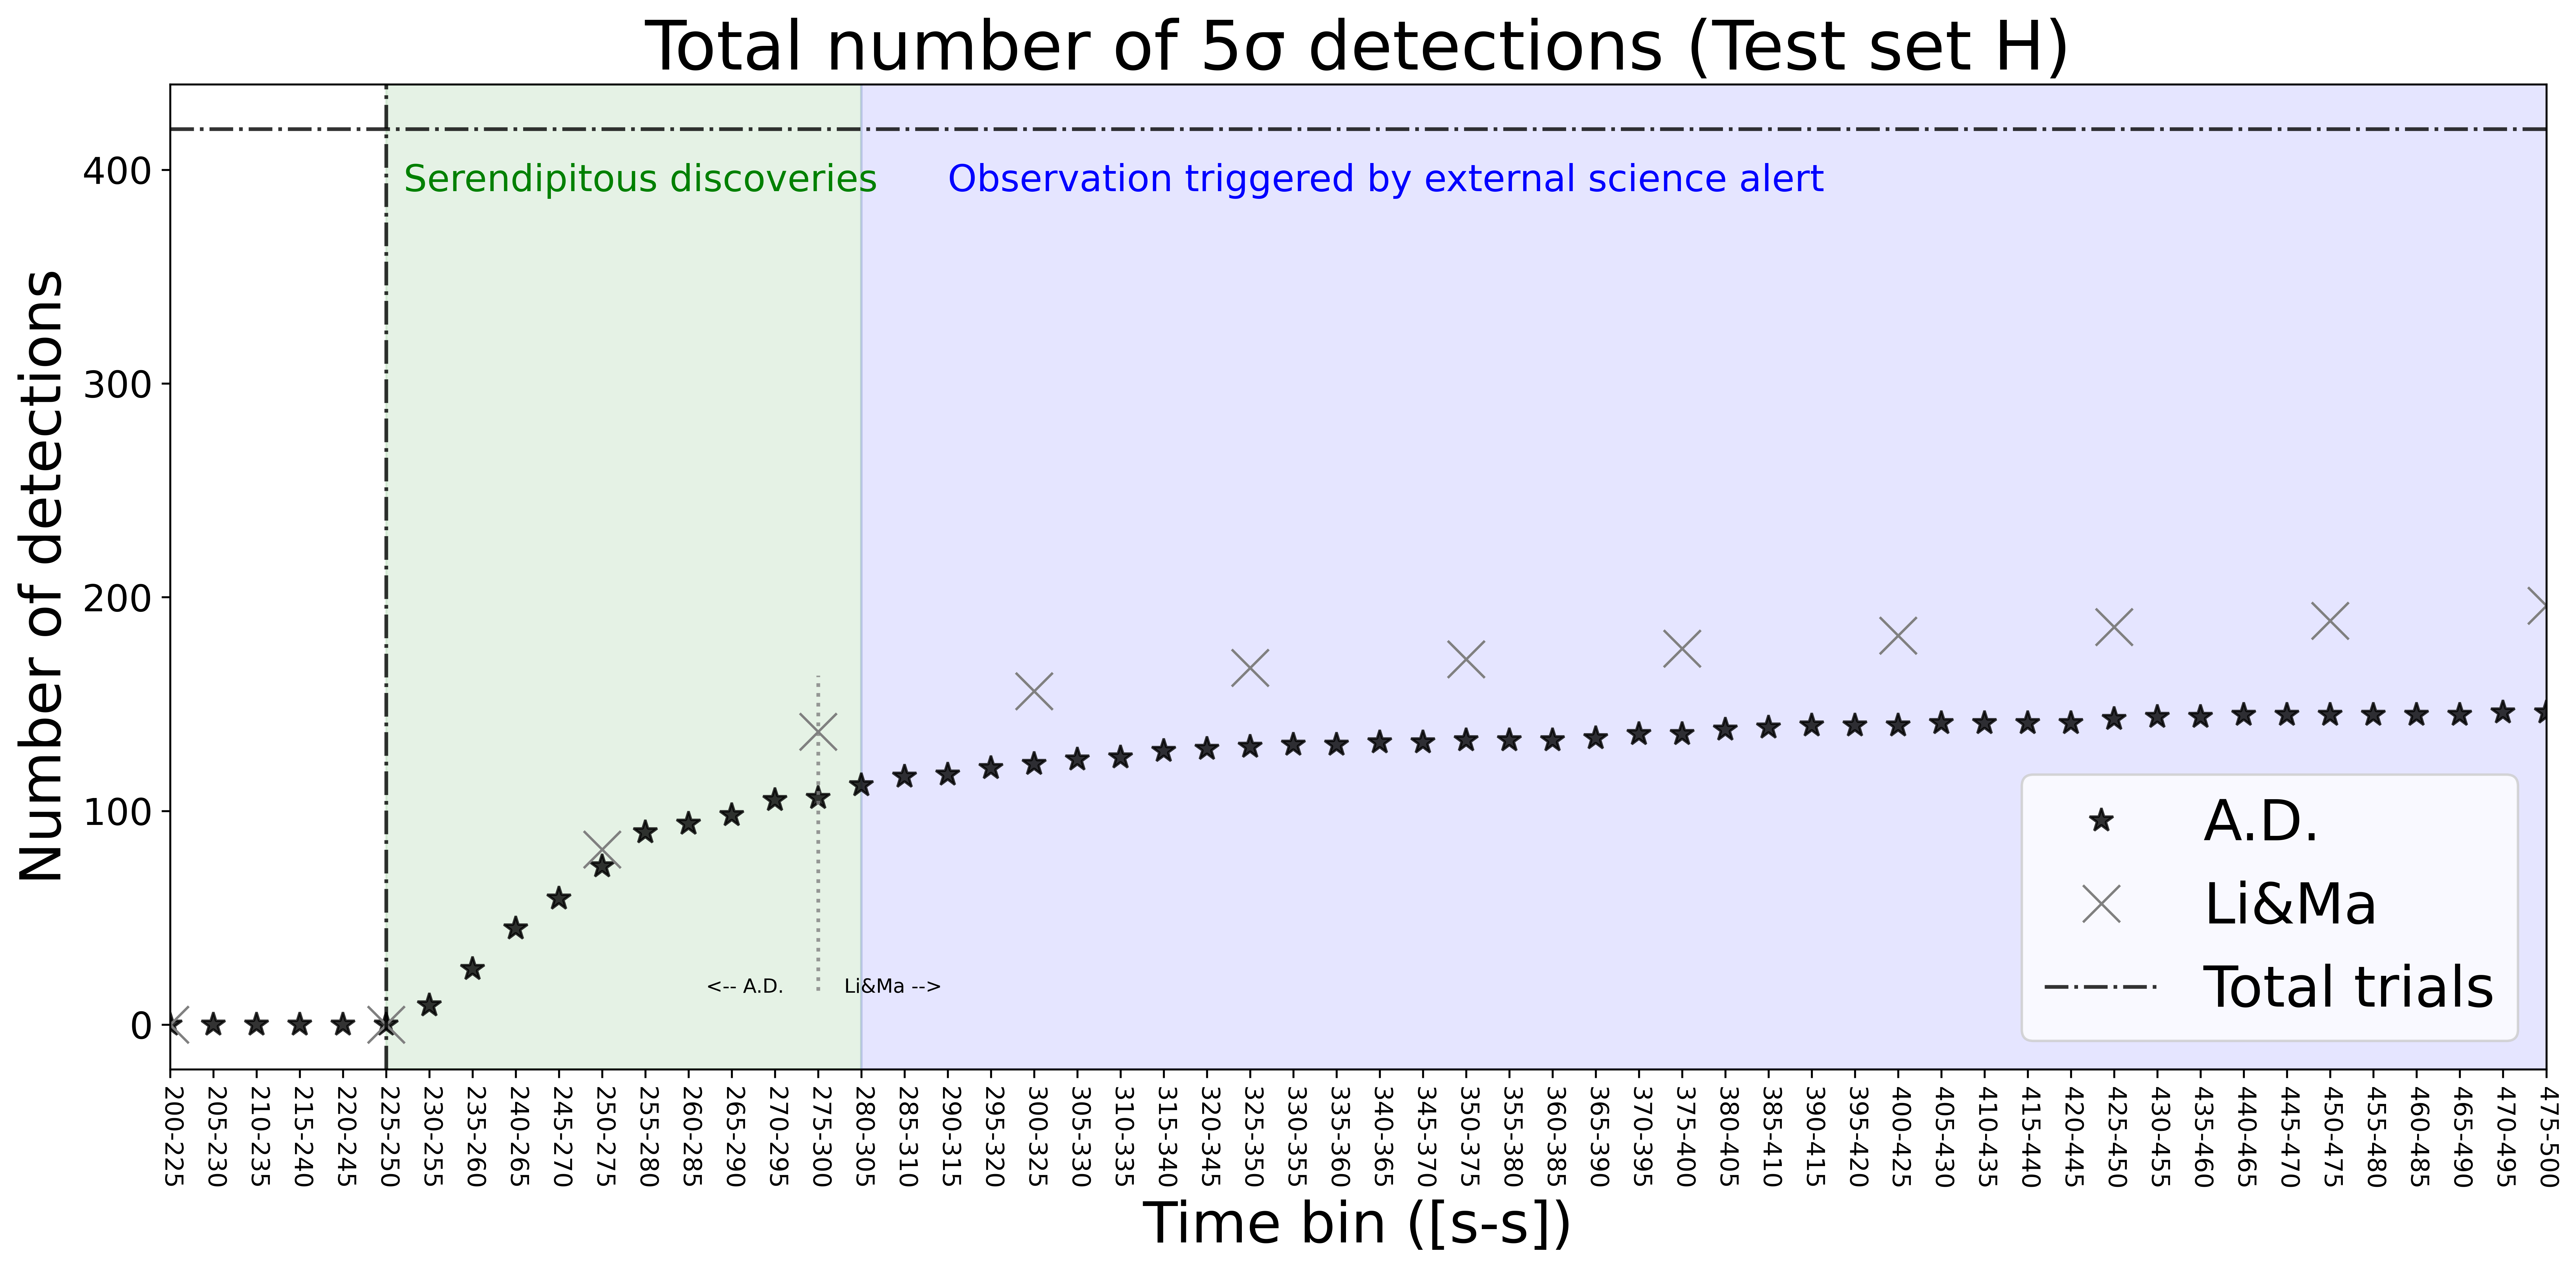

In [44]:
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig
pc = PlotConfig()
fig, ax = plt.subplots(1,1,figsize=pc.fig_size)

cumulative_ad = np.cumsum(counts_ad)
ax.plot(bins_ad[:-1], cumulative_ad, marker="*", markersize=10, linestyle="none", label="A.D.", color="black", alpha=0.8)

cumulative_li_ma = np.cumsum(counts_li_ma)
cumulative_li_ma_reduced = []
bins_li_ma_reduced = []
for i in range(10, 100, 5):
    if i % 5 == 0:
        cumulative_li_ma_reduced.append(cumulative_li_ma[i])
        bins_li_ma_reduced.append(bins_li_ma[i])
ax.plot(bins_li_ma_reduced, cumulative_li_ma_reduced, marker="x", markersize=15, linestyle="none", label="Li&Ma", color="grey", alpha=1)

fig.suptitle("")
ax.set_ylabel("Number of detections")
ax.set_xlabel("Time bin ([s-s])")
ax.set_title("Total number of 5σ detections (Test set H)")
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim(200, 475)
ax.set_xticks([i*5 for i in range(40,96)],sigma_table_rnn.index.values[40:], fontsize=10)

for tick in ax.get_xticklabels():
    tick.set_rotation(-90)

ax.axvline(x = 225, color='black', linestyle="-.", alpha=0.8)    

    
ax.axvline(x = 275, color='grey', linestyle="dotted", alpha=0.8, ymin=0.08, ymax=0.4)    
ax.text(262, 15, '<-- A.D.', color='black', fontsize = 8)
ax.text(278, 15, 'Li&Ma -->', color='black', fontsize = 8)


#ax.text(227, 140, 'GRB start', fontsize = 14, color="red")
ax.axvspan(225, 280, color='green', alpha=0.1)
ax.text(227, 390, 'Serendipitous discoveries', color='green', fontsize = 15)
ax.axvspan(280, 500, color='blue', alpha=0.1)
ax.text(290, 390, 'Observation triggered by external science alert', color='blue', fontsize = 15)

ax.axhline(y = 419, color='black', linestyle="-.", alpha=0.8, label="Total trials")    

ax.legend()

fig.tight_layout()
fig.savefig(Path(output_dir).joinpath(f"ad_vs_li_cumulative_testset_h_id_1.png"), dpi=pc.dpi)

In [45]:
def get_dd(model, templates_detections, sigma, onset_index=45):
    first_detection_indexes = []
    for template_result in templates_detections.values():
        if len(template_result[model][f"{sigma}s_detections_indexes"]) > 0:
            #print(onset_index)
            #print(template_result[model][f"{sigma}s_detections_indexes"])
            first_detection_indexes.append(template_result[model][f"{sigma}s_detections_indexes"][0])
    return round((np.array(first_detection_indexes).mean()-onset_index)*integration_time,2)

In [46]:
def get_detections_in_time(templates_detections, model, tmax, onset_index=45, sigma=5):
    first_detection_indexes = []
    for template_result in templates_detections.values():
        if len(template_result[model][f"{sigma}s_detections_indexes"]) > 0:
            first_detection_indexes.append(template_result[model][f"{sigma}s_detections_indexes"][0])
    detection_time = (np.array(first_detection_indexes)-onset_index)*integration_time
    dt_filterd = [dt for dt in detection_time if dt <= tmax]
    return len(dt_filterd)

print("i", "LiMa","RNN")
#for i in [5, 10, 20, 50, 100]:
li_ma_d = [get_detections_in_time(templates_detections, "li_ma", i) for i in range(5,505,5)]
ad_d = [get_detections_in_time(templates_detections, "rnn", i) for i in range(5,505,5)]

i LiMa RNN


### 3 sigma detections

In [47]:
print(f'Detected by CNN: {np.array([template_result["cnn"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("cnn",templates_detections, 3)} s')
print(f'Detected by RNN: {np.array([template_result["rnn"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("rnn",templates_detections, 3)} s')
print(f'Detected by Li&Ma: {np.array([template_result["li_ma"]["3s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("li_ma",templates_detections, 3)} s')

Detected by CNN: 174 - dd: 52.64 s
Detected by RNN: 237 - dd: 61.81 s
Detected by Li&Ma: 294 - dd: 63.18 s


In [55]:
count_cnn = 0
for template_result in templates_detections.values():
    if template_result["cnn"]["5s_detection"] and not template_result["li_ma"]["5s_detection"]:
        count_cnn += 1
print(f"Detected by CNN but not by Li&Ma: {count_cnn}")

Detected by CNN but not by Li&Ma: 2


In [48]:
count_rnn = 0
for template_result in templates_detections.values():
    if template_result["rnn"]["3s_detection"] and not template_result["li_ma"]["3s_detection"]:
        count_rnn += 1
print(f"Detected by RNN but not by Li&Ma: {count_rnn}")

Detected by RNN but not by Li&Ma: 13


In [49]:
count_rnn = 0
for template_result in templates_detections.values():
    if not template_result["rnn"]["3s_detection"] and template_result["li_ma"]["3s_detection"]:
        count_rnn += 1
print(f"Detected by Li&Ma but not by RNN: {count_rnn}")

Detected by Li&Ma but not by RNN: 70


### 5 sigma detections

In [50]:
def get_detections_in_time(templates_detections, model):
    first_detection_indexes = []
    for template_result in templates_detections.values():
        if len(template_result["li_ma"][f"5s_detections_indexes"]) > 0:
            first_detection_indexes.append(template_result["li_ma"][f"5s_detections_indexes"][0])
    detection_time = (np.array(first_detection_indexes)-45)*integration_time
    dt_filterd = [dt for dt in detection_time if dt <= 50]
    return len(dt_filterd)

print(get_detections_in_time(templates_detections, "li_ma"))

137


In [51]:
print(f'Detected by CNN: {np.array([template_result["cnn"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("cnn",templates_detections, 5)} s')
print(f'Detected by RNN: {np.array([template_result["rnn"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("rnn",templates_detections, 5)} s')
print(f'Detected by Li&Ma: {np.array([template_result["li_ma"]["5s_detection"] for template_result in templates_detections.values()]).sum()} - dd: {get_dd("li_ma",templates_detections, 5)} s')

Detected by CNN: 130 - dd: 47.81 s
Detected by RNN: 146 - dd: 45.62 s
Detected by Li&Ma: 196 - dd: 65.56 s


In [52]:
count_rnn = 0
for template_result in templates_detections.values():
    if template_result["rnn"]["5s_detection"] and not template_result["li_ma"]["5s_detection"]:
        count_rnn += 1
print(f"Detected by RNN but not by Li&Ma: {count_rnn}")

Detected by RNN but not by Li&Ma: 4


In [53]:
count_rnn = 0
for template_result in templates_detections.values():
    if not template_result["rnn"]["5s_detection"] and template_result["li_ma"]["5s_detection"]:
        count_rnn += 1
print(f"Detected by Li&Ma but not by RNN: {count_rnn}")

Detected by Li&Ma but not by RNN: 54


### Sigma plots RNN vs Li&Ma

In [54]:
matplotlib.use("TKAgg", force=True)
%matplotlib inline
from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_model, lima_sigma_table):
    pc = PlotConfig()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    ax.plot(sigma_table_model.index.values, sigma_table_model[template], marker='o', linestyle='--', label="Anomaly Detection", zorder=1)
    

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(10, 100, 5):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_model.index.values[i])

    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=200, label="Li&Ma", color="grey", zorder=10)
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    fig.suptitle("Detection plot")
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel("Timeseries")
    ax.set_ylim(0, 10)
    plt.axvline(x = 45, color = 'grey', linestyle="-.")
    plt.axhline(y = 3, color = 'orange', linestyle="-.")
    plt.axhline(y = 5, color = 'red', linestyle="-.")
    mask = [True if i%2==0 else False for i in range(len(sigma_table_model.index.values))]
    ax.set_xticks(range(0, len(sigma_table_model.index.values), 2), sigma_table_model.index.values[mask], rotation=45)
    ax.legend()
    fig.savefig(Path(output_dir).joinpath(f"detection_plot_{template}_testset_h.png"), dpi=100)
    #plt.show()    
    plt.close()
templates = list(data_manager.data.keys())
    
for template in tqdm(templates):
    sigma_plot(template, sigma_table_rnn, lima_sigma_table)

100%|████████████████████████████████████████████████████████████████████████████████████████| 419/419 [01:27<00:00,  4.80it/s]
